In [1]:
import torch
import torch_pruning as tp
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from train import original_train
from test import test
from pruning import pruning
from experi_pruning_finetuning import experi_pruning_finetuning
from quantization import quantize_qint8

import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from torchsummary import summary
import pandas as pd

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)



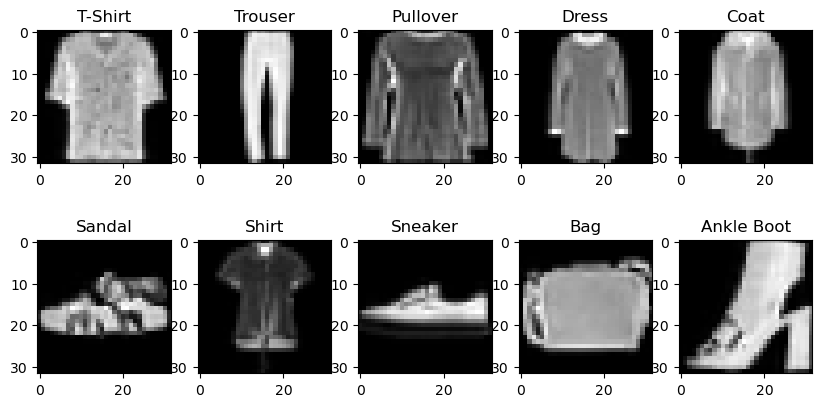

In [2]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root = "data", train = True, download = True, transform = transform)
testset = torchvision.datasets.FashionMNIST(root = "data", train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = trainset, shuffle = True, batch_size = 32)
test_loader = torch.utils.data.DataLoader(dataset = testset, shuffle = False, batch_size = 32)


label_tags = {
    0:'T-Shirt',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle Boot'
}

iter_trainloader = iter(train_loader)
imgs, labels = next(iter_trainloader)
imgs_2, labels_2 = next(iter_trainloader)

figure = plt.figure(figsize = (10,5))
rows, cols = (2,5)
for i in range(0, 10):
    img_idxs = np.argwhere(labels == i)[0]
    if img_idxs.shape[0] == 0:
        print('두번째 loader')
        img_idx = np.argwhere(labels_2 == i)[0][0]
    else: 
        img_idx = img_idxs[0]
    figure.add_subplot(rows, cols, i+1)
    plt.title(label_tags[i])
    plt.imshow(imgs[img_idx].squeeze(), cmap = 'grey')
plt.show()



In [3]:
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Base model train & test

< four metrics >

- accuracy
- inference time
- n_params
- MACs

In [9]:
"""
origin_model = LeNet_5().to(device)
origin_model = original_train(origin_model, device, train_loader)

acc, inference_time = test(origin_model, device, test_loader)
print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')
macs, nparams = tp.utils.count_ops_and_params(origin_model, torch.randn(1, 1, 32, 32).to(device))
print('n_params:', nparams)
print('macs:', macs)

torch.save(origin_model.state_dict(), 'origin_model.pth')
"""


accuracy: 89.230
inference time: 6.880μs
n_params: 61706
macs: 429342.0


In [5]:
import warnings
warnings.filterwarnings('ignore')
                        
origin_model = LeNet_5().to(device)
origin_model.load_state_dict(torch.load('origin_model.pth'))

<All keys matched successfully>

# **[ Pruning ]**

### * Importance score: MEAN of absolute weights per channel
 
### * Global Pruning VS Local Pruning
-> Check Base model's Importance Score per channels

In [97]:
def get_conv_linear_layers(model) -> list:
    layers = []
    for layer in model.modules():
        if isinstance(layer, torch.nn.Linear) and layer.out_features != 10:
            layers.append(layer)
        if isinstance(layer, torch.nn.Conv2d):
            layers.append(layer)
    return layers

In [177]:
def get_channel_importance(model) -> list:
    layers = get_conv_linear_layers(model)
    channel_importance = []
    
    for layer in layers:
        score = layer.weight.abs().flatten(1).mean(1)
        channel_importance.append(score)
    return channel_importance

In [178]:
channel_importance = get_channel_importance(origin_model)

index = [layer_name for l, layer_name in zip(channel_importance, ['conv1', 'conv2', 'linear1', 'linear2']) for j in range(len(l))]
score = torch.concat(channel_importance)

importance_df = pd.DataFrame(score.cpu().detach().numpy(), index = index, columns = ['score'])
importance_df.sort_values('score').head(10)

,score
linear1,0.026652
linear1,0.026750
linear1,0.026937
linear1,0.027543
linear1,0.027880
linear1,0.028515
linear1,0.028595
linear1,0.028675
linear1,0.029311
linear1,0.030388


In [179]:
def plot_scatter_channel_importance(model, model_name, ax):
    channel_importance = get_channel_importance(model) # list
    layer_names = ['conv1', 'conv2', 'linear1', 'linear2']
    
    for idx, (layer, layer_name) in enumerate(zip(channel_importance, layer_names)):
        score = layer.cpu().detach().numpy()
        ax.scatter([idx]*len(score), score, label = layer_name)
        
    ax.legend()
    ax.set_xticks(ticks = range(len(layer_names)), labels = layer_names)
    ax.set_xlabel(model_name)
    ax.set_ylabel('Importance Score')
    ax.set_title('Importance Score of Channels by Layers')


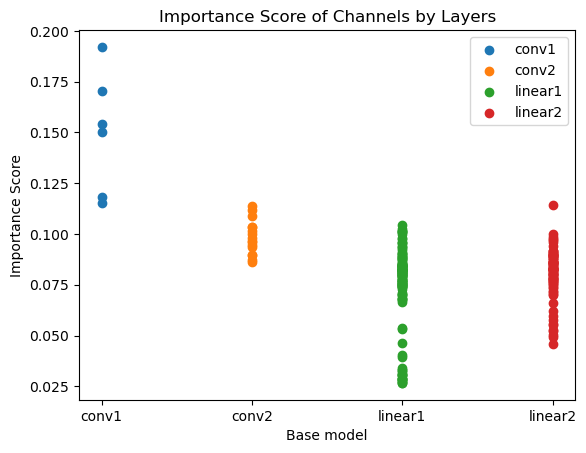

In [180]:
fig, ax = plt.subplots(1)
plot_scatter_channel_importance(origin_model, 'Base model', ax)

- Considering that Base model is not fully optimized(accuracy 89%) -> need to avoid further performance degradation


- conv layers have fewer channels than linear layers, but conv layers play more important role than linear layer based on mean importance score
    -> conv layers contribute significantly to feature extraction
- Applying Global pruning could prune many conv channels -> could result in performance degradation
- Local pruning prunes the channels of layers according to the pruning ratio setting

* To preserve few channels of conv layers, apply `Local pruning`

### * Performance comparison w/ and w/o Finetuning After Pruning on Pruning ratio 0.5



### pruning ratio : 50%

In [19]:
# Just Pruning, Before finetuning
model = copy.deepcopy(origin_model)
_model_50, _acc_50, _params_50, _mmac_50, _inference_time_50, _df_50 = pruning(model, 0.5, device, test_loader, 5)
_df_50

,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,9.156561
step 1,88.81,48737,330483,6.837726
step 2,83.14,37391,243147,6.965113
step 3,77.78,29919,225576,6.764197
step 4,57.239998,21194,153236,6.652498
step 5,57.17,15738,140156,6.782722


In [20]:
# pruning + finetuning
model = copy.deepcopy(origin_model)
model_50, acc_50, params_50, mmac_50, inference_time_50, df_50 = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)
df_50

,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,7.439089
step 1,91.299995,48737,330483,6.942058
step 2,91.11,37391,243147,6.712008
step 3,90.99,29919,225576,7.009006
step 4,87.53,21194,153236,6.753182
step 5,88.259995,15738,140156,9.303975


In [65]:
def make_list(m):
    return [i.item() for i in m]

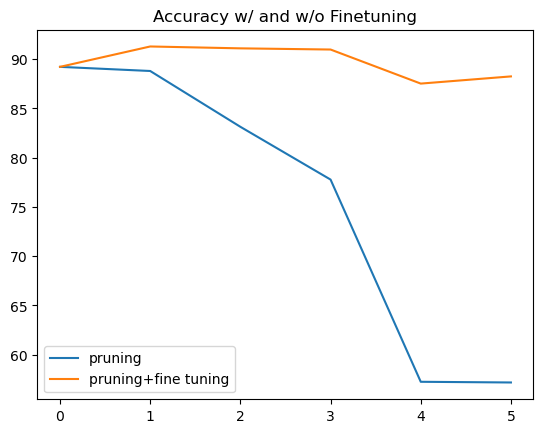

In [22]:
a = list(range(6))
b = make_list(_acc_50)

x = list(range(6))
y = make_list(acc_50)

plt.title('Accuracy w/ and w/o Finetuning')
plt.plot(a,b, label = 'pruning')
plt.plot(x,y, label = 'pruning+fine tuning')
plt.legend()

plt.show()

### * Iterative step comparison on Local pruning ratio 0.5

In [9]:
model = copy.deepcopy(origin_model)
model_5, acc_5, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)

model = copy.deepcopy(origin_model)
model_4, acc_4, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 4, 1e-4)

model = copy.deepcopy(origin_model)
model_3, acc_3, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 3, 1e-4)

model = copy.deepcopy(origin_model)
model_2, acc_2, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 2, 1e-4)

model = copy.deepcopy(origin_model)
model_1, acc_1, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 1, 1e-4)

In [11]:
pd.DataFrame({'Acc(%)':[acc_1[0], acc_1[-1], acc_2[-1], acc_3[-1], acc_4[-1], acc_5[-1]]},
             index = ['Base'] + list(range(1, 6)))

,Acc(%)
Base,89.229996
1,86.57
2,85.659996
3,87.93
4,87.67
5,88.259995


Set the Iterative step to 5 based on the Accuracy results

### * Finetuning learning rate comparison on pruning ratio 0.5

In [12]:
# pruning + finetuning
model = copy.deepcopy(origin_model)
model_4, acc_4, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)

model = copy.deepcopy(origin_model)
model_5, acc_5, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-5)

model = copy.deepcopy(origin_model)
model_6, acc_6, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-6)

In [14]:
import pandas as pd
pd.DataFrame({"Accuracy(%)" : [acc_4[0].round(), acc_4[-1], acc_5[-1], acc_6[-1]]},
             index = ['Base', 'lr * 1/10', 'lr * 1/100', 'lr * 1/1000'])

,Accuracy(%)
Base,89.0
lr * 1/10,88.259995
lr * 1/100,81.75
lr * 1/1000,57.82


Select Finetuning learning rate 1e-4 (1/10 * training lr)

### * Performance comparison conv+linear pruning VS only linear pruning (comparison under same parameter: 75% parameter reduction from the base model) 

1) Pruning applied to the entire layer (Conv + Linear) -> pruning ratio 0.5 (75% reduction)
2) Pruning applied to Linear layers only -> pruning ratio 0.75 (75% reduction)

In [12]:
model = copy.deepcopy(origin_model)
model_mix_pruning, acc_mix_pruning, param_mix_pruning, mac_mix_pruning, inference_time_mix_pruning, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, "prune_conv_and_linear")

model = copy.deepcopy(origin_model)
model_only_prune_linear_layer, acc_only_prune_linear_layer, param_only_prune_linear_layer, mac_only_prune_linear_layer, inference_time_only_prune_linear_layer, _ = experi_pruning_finetuning(model, 0.75, device, test_loader, 5, 1e-4, "only_prune_linear_layer")

In [13]:
import pandas as pd
pd.DataFrame({'# of parameters': [param_mix_pruning[0], param_mix_pruning[-1], param_only_prune_linear_layer[-1]], 
              'Acc(%)':[acc_mix_pruning[0], acc_mix_pruning[-1], acc_only_prune_linear_layer[-1]],
              'MACs':[mac_mix_pruning[0], mac_mix_pruning[-1], mac_only_prune_linear_layer[-1]],
              'Inference time': [inference_time_mix_pruning[0], inference_time_mix_pruning[-1], inference_time_only_prune_linear_layer[-1]]},
             index = ['Base', 'conv+linear pruning', 'only linear pruning'])

,# of parameters,Acc(%),MACs,Inference time
Base,61706,89.229996,429342,9.623528
conv+linear pruning,15738,88.259995,140156,6.801128
only linear pruning,15473,90.01,383109,7.143116


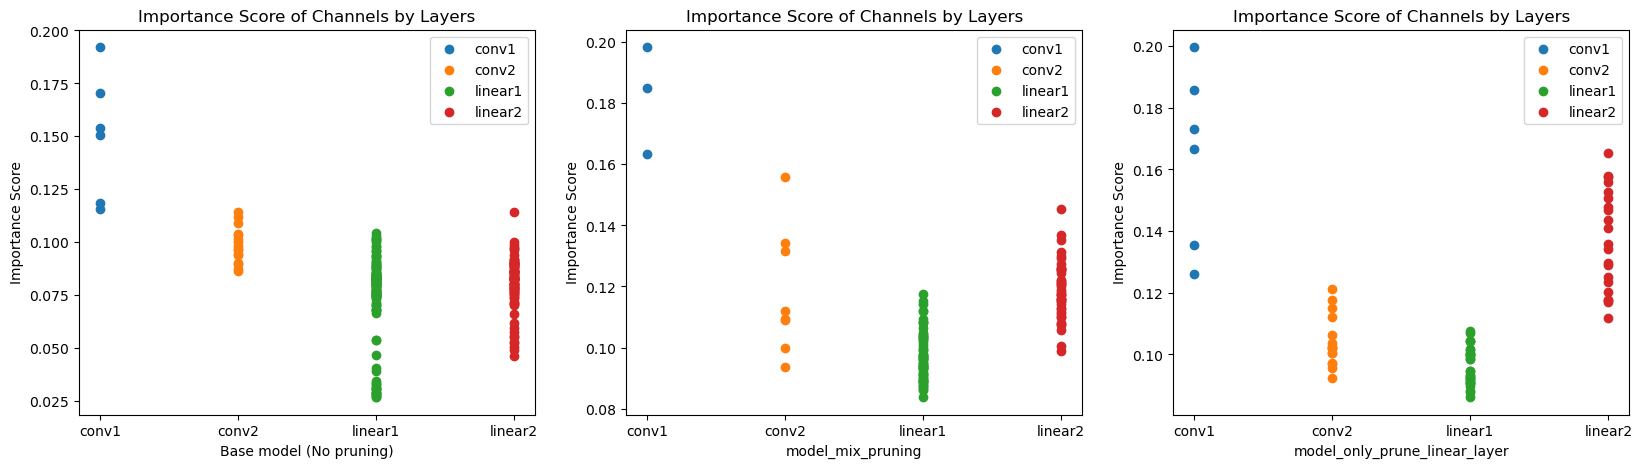

In [239]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
plot_scatter_channel_importance(origin_model, 'Base model (No pruning)', ax[0], )
plot_scatter_channel_importance(model_mix_pruning, 'model_mix_pruning', ax[1])
plot_scatter_channel_importance(model_only_prune_linear_layer, 'model_only_prune_linear_layer', ax[2])

reduce # of parameters to 1/4 * base_model
- conv + linear pruning : pruning ratio 0.5
- only linear pruning : pruning ratio 0.75

- conv + linear pruning : 1% accuracy dropped, but significant reduction on MACs due to conv layer pruning (conv- computaionally expensive)
- only linear pruning : 1% accuracy improved, but no significant reduction on MACs due to no conv layer pruning
- conv + linear pruning's inference time is faster than only linear pruning due to fewer operations

-> SELECT conv + linear pruning for significant reduction on MACs w/ only 1% accuracy drop

### * Accuracy, number of parameters, MACs, and Inference time comparison based on Pruning Ratio

### pruning ratio : 50%

In [18]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_50, acc_50, params_50, mmac_50, inference_time_50, df_50 = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)
df_50

,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,7.370472
step 1,91.299995,48737,330483,6.483197
step 2,91.11,37391,243147,6.564164
step 3,90.99,29919,225576,6.471109
step 4,87.53,21194,153236,6.386781
step 5,88.259995,15738,140156,6.315064


### pruning ratio : 60%

In [19]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_60, acc_60, params_60, mmac_60, inference_time_60, df_60 = experi_pruning_finetuning(model, 0.6, device, test_loader, 5, 1e-4)
df_60

,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,7.425475
step 1,91.28999,47227,328973,6.360364
step 2,91.009995,35143,240899,6.226277
step 3,88.15,24535,164201,6.292248
step 4,87.78,16297,140715,6.313419
step 5,85.28,9563,82741,6.605887


### Pruning ratio: 70%

In [20]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_70, acc_70, params_70, mmac_70, inference_time_70, df_70 = experi_pruning_finetuning(model, 0.7, device, test_loader, 5, 1e-4)
df_70

,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,7.549691
step 1,91.06,43564,312736,6.298184
step 2,90.45,30781,226438,6.628084
step 3,87.119995,20206,152248,6.315970
step 4,85.899994,11839,90166,6.373119
step 5,77.4,4951,36789,5.971313


### pruning ratio : 80%

In [22]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_80, acc_80, params_80, mmac_80, inference_time_80, df_80 = experi_pruning_finetuning(model, 0.8, device, test_loader, 5, 1e-4)
df_80

,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,8.660936
step 1,91.02,42148,311320,6.345534
step 2,90.01,26699,212257,6.453538
step 3,88.1,16297,140715,6.312513
step 4,82.659996,7355,75384,6.041837
step 5,73.77,2406,31570,5.985570


### pruning ratio : 90%

In [23]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_90, acc_90, params_90, mmac_90, inference_time_90, df_90 = experi_pruning_finetuning(model, 0.9, device, test_loader, 5, 1e-4)
df_90

,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,7.833099
step 1,90.66,40787,256642,6.336737
step 2,87.689995,24535,164201,6.280947
step 3,85.71999,12607,90934,6.225419
step 4,77.42,4485,36323,5.970645
step 5,35.98,524,24340,5.964351


## * FINAL RESULTS

(comparison of the four metrics based on pruning ratio)

In [24]:
import pandas as pd
pd.DataFrame({'acc(%)':[acc_50[0], acc_50[-1], acc_60[-1], acc_70[-1], acc_80[-1], acc_90[-1]],
              'n_params' : [params_50[0], params_50[-1], params_60[-1], params_70[-1], params_80[-1], params_90[-1]],
              'MACs': [mmac_50[0], mmac_50[-1], mmac_60[-1], mmac_70[-1], mmac_80[-1], mmac_90[-1]],
              'inference time(μs)': [inference_time_50[0], inference_time_50[-1], inference_time_60[-1], inference_time_70[-1], inference_time_80[-1], inference_time_90[-1]],},
             index = ['Base'] + [f'{i}%' for i in range(50, 100, 10)])


,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,7.370472
50%,88.259995,15738,140156,6.315064
60%,85.28,9563,82741,6.605887
70%,77.4,4951,36789,5.971313
80%,73.77,2406,31570,5.985570
90%,35.98,524,24340,5.964351


### * Visualization across Pruning Ratios

### Accuracy

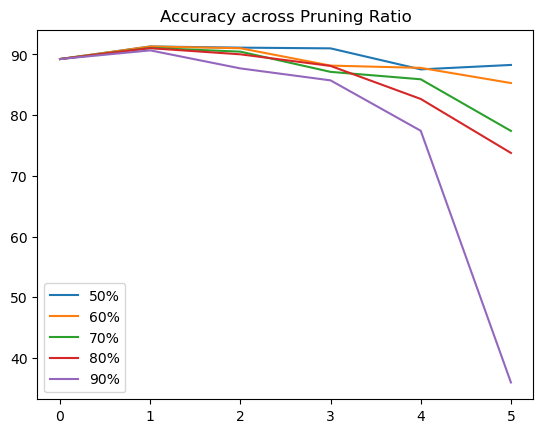

In [66]:
x = list(range(6))

plt.title('Accuracy across Pruning Ratio')
plt.plot(x, make_list(acc_50), label='50%')
plt.plot(x, make_list(acc_60), label='60%')
plt.plot(x, make_list(acc_70), label='70%')
plt.plot(x, make_list(acc_80), label='80%')
plt.plot(x, make_list(acc_90), label='90%')
plt.legend()

plt.show()

### number of params

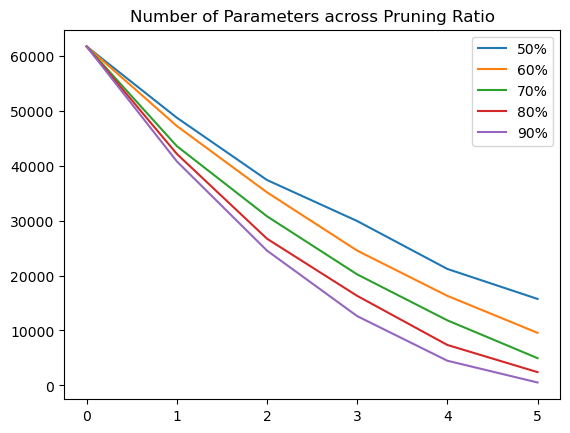

In [67]:
x = list(range(6))

plt.title('Number of Parameters across Pruning Ratio')
plt.plot(x, params_50, label='50%')
plt.plot(x, params_60, label='60%')
plt.plot(x, params_70, label='70%')
plt.plot(x, params_80, label='80%')
plt.plot(x, params_90, label='90%')
plt.legend()

plt.show()

### MACs

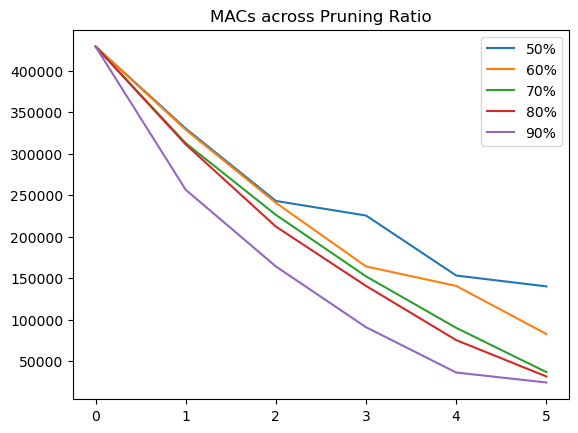

In [68]:
x = list(range(6))

plt.title('MACs across Pruning Ratio')
plt.plot(x, mmac_50, label='50%')
plt.plot(x, mmac_60, label='60%')
plt.plot(x, mmac_70, label='70%')
plt.plot(x, mmac_80, label='80%')
plt.plot(x, mmac_90, label='90%')
plt.legend()

plt.show()

## Inference time

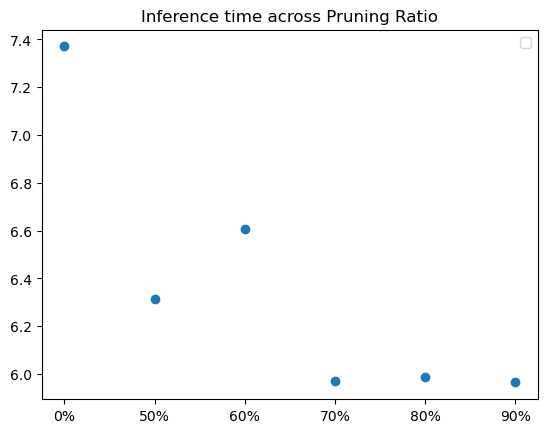

In [69]:
x = ['0%'] + [str(i) + '%' for i in range(50, 100, 10)]
y = [inference_time_50[0], inference_time_50[-1], inference_time_60[-1], inference_time_70[-1], inference_time_80[-1], inference_time_90[-1]]
plt.title('Inference time across Pruning Ratio')
plt.scatter(x, y)
plt.legend()

plt.show()

### * VERIFY if pruning followed the set pruning ratio

In [29]:
def num_channel(model): 
    total = 0
    for param_tensor in list(origin_model.state_dict().keys())[:-2]:
        total += model.state_dict()[param_tensor].shape[0]
    return total

base = num_channel(origin_model)

def calc_ratio(model):
    total = num_channel(model)
    ratio = round(1- total / base, 1) 
    return total, ratio 

In [30]:
c_50 = calc_ratio(model_50)
c_60 = calc_ratio(model_60)
c_70 = calc_ratio(model_70)
c_80 = calc_ratio(model_80)
c_90 = calc_ratio(model_90)

print('################# number of channels ##################')
print(f"Base: {base}")
print(f"50%: {c_50[0]} channels  -> pruned ratio: {c_50[1]}")
print(f"60%: {c_60[0]} channels  -> pruned ratio: {c_60[1]}")
print(f"70%: {c_70[0]} channels  -> pruned ratio: {c_70[1]}")
print(f"80%: {c_80[0]} channels   -> pruned ratio: {c_80[1]}")
print(f"90%: {c_90[0]} channels   -> pruned ratio: {c_90[1]}")

################# number of channels ##################
Base: 452
50%: 226 channels  -> pruned ratio: 0.5
60%: 178 channels  -> pruned ratio: 0.6
70%: 132 channels  -> pruned ratio: 0.7
80%: 86 channels   -> pruned ratio: 0.8
90%: 42 channels   -> pruned ratio: 0.9


### * Select a pruning ratio of **50%** for quantization

In [33]:
#torch.save(model_50.state_dict(), 'model_50.pth')

# **[ Quantization ]**

In [34]:
quantize_qint8_model50 = quantize_qint8(model_50.to('cpu'))
quantize_qint8_model50

# Linear -> DynamicQuantizedLinear 

LeNet_5(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (fc1): DynamicQuantizedLinear(in_features=200, out_features=60, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=60, out_features=42, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc3): DynamicQuantizedLinear(in_features=42, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [63]:
print('#########################################')
print('########### Before Quantization #########')
print('#########################################')

acc, inference_time = test(model_50.to('cpu'), 'cpu', test_loader)
macs, nparams = tp.utils.count_ops_and_params(model_50.to('cpu'), torch.randn(1, 1, 32, 32))

print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')
print('n_params:', nparams)
print('macs:', macs)

print()
print('#########################################')
print('############ After Quantization #########')
print('#########################################')

acc, inference_time = test(quantize_qint8_model50, 'cpu', test_loader)
macs, nparams = tp.utils.count_ops_and_params(quantize_qint8_model50, torch.randn(1, 1, 32, 32))

print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')
print('n_params:', nparams)
print('macs:', macs)

#########################################
########### Before Quantization #########
#########################################
accuracy: 88.260
inference time: 14.269μs
n_params: 15738
macs: 140156.0

#########################################
############ After Quantization #########
#########################################
accuracy: 88.210
inference time: 16.366μs
n_params: 686
macs: 125104.0


### Summary of pruned 50%

In [36]:
summary(model_50, (1,32,32), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 3, 28, 28]              78
         MaxPool2d-2            [32, 3, 14, 14]               0
            Conv2d-3            [32, 8, 10, 10]             608
         MaxPool2d-4              [32, 8, 5, 5]               0
            Linear-5                   [32, 60]          12,060
            Linear-6                   [32, 42]           2,562
            Linear-7                   [32, 10]             430
Total params: 15,738
Trainable params: 15,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.99
Params size (MB): 0.06
Estimated Total Size (MB): 1.17
----------------------------------------------------------------


### Summary of pruned + quantized model

In [37]:
summary(quantize_qint8_model50, (1,32,32), batch_size=32, device='cpu')


# using torchsummary, parameters for FCL are all recorded as 0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 3, 28, 28]              78
         MaxPool2d-2            [32, 3, 14, 14]               0
            Conv2d-3            [32, 8, 10, 10]             608
         MaxPool2d-4              [32, 8, 5, 5]               0
            Linear-5                   [32, 60]               0
            Linear-6                   [32, 42]               0
            Linear-7                   [32, 10]               0
Total params: 686
Trainable params: 686
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.99
Params size (MB): 0.00
Estimated Total Size (MB): 1.12
----------------------------------------------------------------


After quantization, the number of parameters changed from 15738 -> 686. Why?

Check why the model parameters decrease after quantization











In [38]:
quantize_qint8_model50.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.scale', 'fc1.zero_point', 'fc1._packed_params.dtype', 'fc1._packed_params._packed_params', 'fc2.scale', 'fc2.zero_point', 'fc2._packed_params.dtype', 'fc2._packed_params._packed_params', 'fc3.scale', 'fc3.zero_point', 'fc3._packed_params.dtype', 'fc3._packed_params._packed_params'])

In [41]:
fc_list = ['fc1', 'fc2', 'fc3']
fc_nparams = []

for i in fc_list:
    n = i + '._packed_params._packed_params'
    weight = quantize_qint8_model50.state_dict()[n][0].numel()
    bias = quantize_qint8_model50.state_dict()[n][1].numel()

    fc_nparams.append(weight+bias)

# After Quantization 
print('################# check number of Parameters after quantization ##################')
for idx, i in enumerate(fc_nparams):
    print(f'fc{idx+1}:', i)
    
# same !!
# It is correct that the number of parameters has not changed

################# check number of Parameters after quantization ##################
fc1: 12060
fc2: 2562
fc3: 430


After quantization, the model's parameter storage format changes

-> the total number of parameters remains the same with 50% pruned model

## * CHECK THE CHANGED PRAMETER SIZE

In [73]:
import os

def params_size(model, model_name):
    torch.save(model.state_dict(), model_name + '.p')
    size = os.path.getsize(model_name + '.p')
    return round(size / 1024)  # to KB

base = params_size(origin_model, "origin_model")
pruned_50 = params_size(model_50, "model_50")
quantized_50 = params_size(quantize_qint8_model50, "quantized_model50")

print('################# Parameter Size Comparison ##################')
print(f"Base Model Size: {base} KB")
print(f"50% Pruned Model Size: {pruned_50} KB  -> Reduction: {round((1 - pruned_50 / base) * 100, 2)}%")
print(f"50% Pruned + Quantized Model Size: {quantized_50} KB  -> Reduction: {round((1 - quantized_50 / base) * 100, 2)}%")

pd.DataFrame({'Acc(%)': [acc_50[0], acc_50[-1], acc.numpy()],
              '# of params':[61706, 15738, 15738],
             'param size(KB)': [base, pruned_50, quantized_50],
              },
             index = ['Base', '50% pruned', '50% pruned+quantization'])


################# Parameter Size Comparison ##################
Base Model Size: 245 KB
50% Pruned Model Size: 65 KB  -> Reduction: 73.47%
50% Pruned + Quantized Model Size: 23 KB  -> Reduction: 90.61%


,Acc(%),# of params,param size(KB)
Base,89.229996,61706,245
50% pruned,88.259995,15738,65
50% pruned+quantization,88.21,15738,23
